## 1D Model

In [221]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.analytic import UpperConfidenceBound, ProbabilityOfImprovement
from botorch.optim import optimize_acqf
from botorch.cross_validation import gen_loo_cv_folds
from botorch.posteriors.gpytorch import GPyTorchPosterior
import math
import GPy

## Identify and plot the objective function

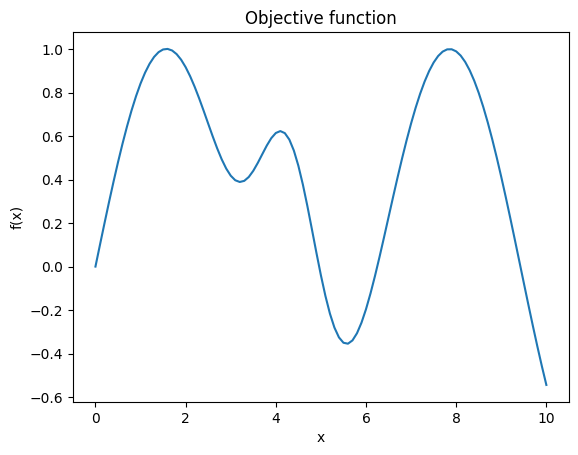

In [222]:
def F(X):
    y = []
    for x in X:
        y.append(np.sin(x) + 1.5 * np.exp(-(x - 4.3) ** 2))
    return torch.tensor(y)

x = np.linspace(0,10,101)
y = F(x)
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Objective function")
plt.show()

## Retrive initial dataset

(tensor([[0.4825],
         [3.0044],
         [3.8487],
         [5.0078],
         [9.4686],
         [8.9044],
         [4.1730],
         [0.7377],
         [6.5154],
         [9.0975],
         [7.0950],
         [0.8262],
         [0.0720],
         [5.4138],
         [0.4715],
         [7.0045],
         [0.6032],
         [1.4417],
         [5.9323],
         [2.3458]]),
 tensor([[ 0.4640],
         [ 0.4167],
         [ 0.5740],
         [-0.0478],
         [-0.0438],
         [ 0.4972],
         [ 0.6180],
         [ 0.6726],
         [ 0.2412],
         [ 0.3215],
         [ 0.7261],
         [ 0.7354],
         [ 0.0719],
         [-0.3301],
         [ 0.4542],
         [ 0.6614],
         [ 0.5673],
         [ 0.9921],
         [-0.2393],
         [ 0.7474]]),
 0.9920967817306519)

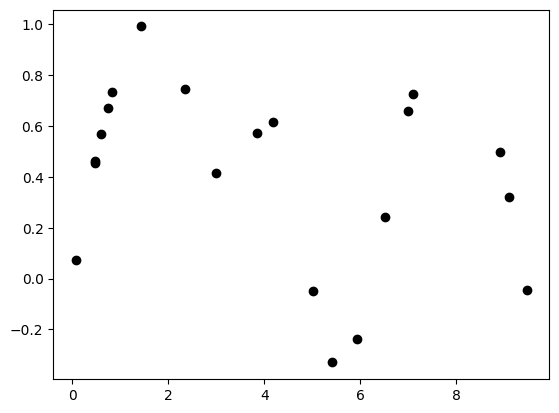

In [242]:
n = 20 # Number of training points
train_x = torch.rand(n,1)*10
train_y = F(train_x).unsqueeze(-1)
best_observed = train_y.max().item()
plt.plot(train_x,train_y,'o', color = 'black')
plt.show
train_x,train_y,best_observed

## Fit GP model

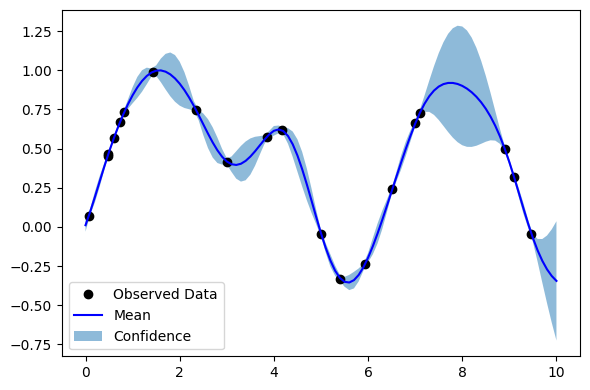

In [243]:
model = SingleTaskGP(train_x,train_y)
mll = ExactMarginalLogLikelihood(model.likelihood,model)
fit_gpytorch_model(mll)

# Plot results
model.eval()

# Initialize plot
f,ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'ko')
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()

## Acquistion function

In [257]:
EI = qExpectedImprovement(
    model = model,
    best_f = best_observed
)

## Optimise acquisition function

In [258]:
candidates_x,_ = optimize_acqf(
    acq_function = EI,
    bounds = torch.tensor([[0.],[10.]]),
    q = 10, # Number of suggested candidates
    num_restarts = 200,
    raw_samples = 512
)
candidates_x
candidates_y = F(candidates_x).unsqueeze(-1)

candidates_x,candidates_y

(tensor([[ 0.0000],
         [ 3.1286],
         [ 1.2565],
         [10.0000],
         [ 1.7311],
         [ 6.8885],
         [ 8.1890],
         [ 3.7686],
         [ 7.6573],
         [ 2.2771]]),
 tensor([[ 1.3995e-08],
         [ 3.9332e-01],
         [ 9.5115e-01],
         [-5.4402e-01],
         [ 9.8922e-01],
         [ 5.7083e-01],
         [ 9.4439e-01],
         [ 5.4424e-01],
         [ 9.8074e-01],
         [ 7.8584e-01]]))

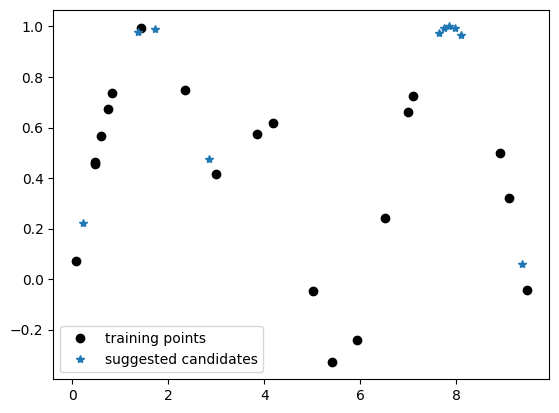

In [247]:
plt.plot(train_x,train_y,'o', color = 'black')
plt.plot(candidates_x,candidates_y,'*')
plt.legend(['training points','suggested candidates'])
plt.show()

## Take in suggested data, forming new training dataset

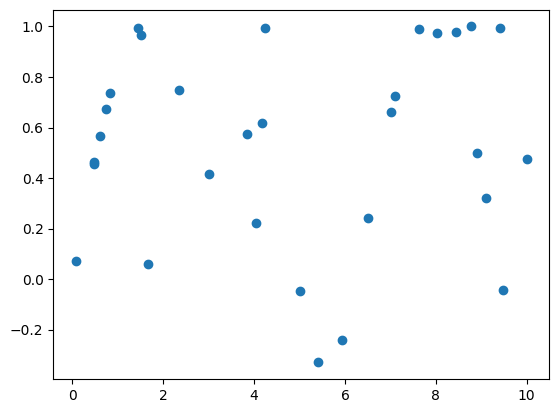

In [248]:
combine_x = (train_x,candidates)
combine_y = (train_y,candidates_y)
posterior_x = torch.cat(combine_x, dim = 0)
posterior_y = torch.cat(combine_y, dim = 0)
posterior_x,posterior_y
plt.plot(posterior_x,posterior_y,'o')

## Posterior model

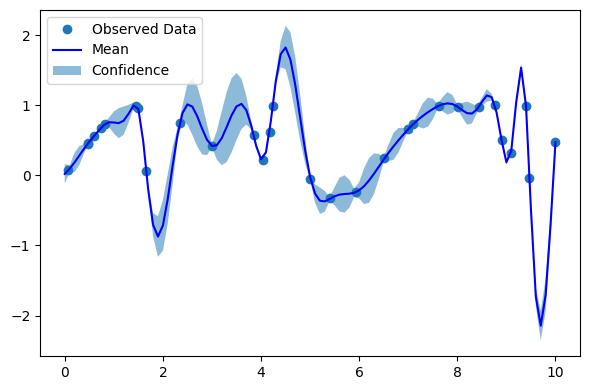

In [252]:
posterior_model = SingleTaskGP(posterior_x,posterior_y,)
mll = ExactMarginalLogLikelihood(posterior_model.likelihood,model)
fit_gpytorch_model(mll)

# Plot
posterior_model.eval()
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 10]
test_x = torch.linspace(0, 10, 101)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = posterior_model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(posterior_x.cpu().numpy(), posterior_y.cpu().numpy(), 'o',)
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()
plt.show()